<a href="https://colab.research.google.com/github/lol-andy1/STAT421Project/blob/main/STAT421Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install swig only if installing gymnasium[box2d] gives an error
!pip install swig
!pip install gymnasium[box2d]

In [ ]:
import torch
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange
from collections import deque

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
env = gym.make("BipedalWalker-v3")
test_env = gym.make("BipedalWalker-v3")
act_space = env.action_space.shape[0]
obs_space = env.observation_space.shape[0]

In [ ]:
# Generic neural network
class MLP(nn.Module):
  def __init__(self, input_size, width, output_size):
    super(MLP, self).__init__()

    self.layers = nn.Sequential(
      nn.Linear(input_size, width), nn.ReLU(),
      nn.Linear(width, width), nn.ReLU(),
      nn.Linear(width, output_size)
    )

  def forward(self, input):
    output = self.layers(input)
    return output

In [ ]:
# Experience buffer
class ExperienceBuffer():
  def __init__(self, buffer_size):
    self.obs_buf = deque(maxlen=buffer_size)
    self.rew_buf = deque(maxlen=buffer_size)
    self.act_buf = deque(maxlen=buffer_size)
    self.obs2_buf = deque(maxlen=buffer_size)
    self.done_buf = deque(maxlen=buffer_size)

  def add(self, obs, rew, act, obs2, done):
    self.obs_buf.append(obs)
    self.rew_buf.append(rew)
    self.act_buf.append(act)
    self.obs2_buf.append(obs2)
    self.done_buf.append(done)

  def sample_minibatch(self, batch_size):
    indices = np.random.randint(len(self.obs_buf), size=batch_size)

    batch_obs = [self.obs_buf[i] for i in indices]
    batch_rew = [self.rew_buf[i] for i in indices]
    batch_act = [self.act_buf[i] for i in indices]
    batch_obs2 = [self.obs2_buf[i] for i in indices]
    batch_done = [self.done_buf[i] for i in indices]

    return batch_obs, batch_rew, batch_act, batch_obs2, batch_done

  def __len__(self):
      return len(self.obs_buf)

In [ ]:
# Initialize the 4 neural networks needed for DDPG
actor = MLP(obs_space, 64, act_space)
critic = MLP(obs_space + act_space, 64, 1)
target_actor = MLP(obs_space, 64, act_space)
target_actor.load_state_dict(actor.state_dict())
target_critic = MLP(obs_space + act_space, 64, 1)
target_critic.load_state_dict(critic.state_dict())

actor = actor.to(device)
critic = critic.to(device)
target_actor = target_actor.to(device)
target_critic = target_critic.to(device)

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=5e-4)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=5e-3)

In [ ]:
obs = env.reset()
obs = obs[0]
buffer = ExperienceBuffer(100000)
step_count = 0
trace_rew = []
trace_test = []
max_step = 1000

mu = 0.0
theta=0.1
sigma=0.2
ou_noise = torch.ones(act_space) * mu
ou_noise = ou_noise.to(device)

In [ ]:
def soft_update(target, online):
  for target_param, online_param in zip(target.parameters(), online.parameters()):
    target_param.data.copy_(target_param.data * (1.0 - 0.003) + online_param.data * 0.003)

def test_agent():
  test_rew = []
  # Let the agent play 10 games and return it's avg reward
  for i in range(10):
    done = False
    ep_rew = 0
    ep_step = 0
    obs = test_env.reset()
    obs = obs[0]

    while not done:
      obs = torch.tensor(obs)
      obs = obs.to(device)
      act = torch.tanh(actor(obs)) * env.action_space.high[0]
      obs, rew, done, _, _ = test_env.step(act.cpu().numpy())
      ep_rew += rew
      ep_step += 1
      if ep_rew < -200:
        done = True
    test_rew.append(ep_rew)
  return np.mean(test_rew)

In [ ]:
# Main training loop
for ep in trange(2001):
  done = False
  ep_rew = 0
  ep_step = 0

  while not done:

    obs = torch.tensor(obs)
    obs = obs.to(device)
    act = torch.tanh(actor(obs)) * env.action_space.high[0]
    # ou_noise = torch.randn(act_space) * 0.15
    # ou_noise = ou_noise.to(device)
    ou_noise = ou_noise - theta * (ou_noise - mu) + sigma * torch.randn(act_space).to(device)
    act = torch.clamp(act + ou_noise, -1.0, 1.0)
    obs2, rew, done, _, _ = env.step(act.detach().cpu().numpy())
    buffer.add(obs.detach().cpu().numpy(), rew, act.detach().cpu().numpy(), obs2, done)

    obs = obs2
    ep_rew += rew
    step_count += 1
    ep_step += 1
    if ep_rew < -200:
      done = True

    if len(buffer) > 64:
      # sample a mini batch from the buffer
      batch_obs, batch_rew, batch_act, batch_obs2, batch_done = buffer.sample_minibatch(64)

      batch_obs = torch.tensor(np.array(batch_obs))
      batch_obs2 = torch.tensor(np.array(batch_obs2))
      batch_act = torch.tensor(np.array(batch_act))
      batch_rew = torch.tensor(batch_rew)
      batch_done = torch.tensor(batch_done).int()

      # GPU
      batch_obs = batch_obs.to(device)
      batch_obs2 = batch_obs2.to(device)
      batch_act = batch_act.to(device)
      batch_rew = batch_rew.to(device)
      batch_done = batch_done.to(device)

      with torch.no_grad():
        act_target = torch.tanh(target_actor(batch_obs2)) * env.action_space.high[0]
        q_target = target_critic(torch.cat((batch_obs2, act_target), dim=1))
        y = batch_rew + 0.99 * (1-batch_done)*q_target

      q_value = critic(torch.cat((batch_obs, batch_act), dim=1))
      loss_critic = torch.mean((q_value - y) ** 2)
      critic_optimizer.zero_grad()
      loss_critic.backward()
      critic_optimizer.step()

      batch_obs = batch_obs.clone().detach().requires_grad_(True)
      act_policy = torch.tanh(actor(batch_obs)) * env.action_space.high[0]
      loss_actor = -torch.mean(critic(torch.cat((batch_obs, act_policy), dim=1)))
      actor_optimizer.zero_grad()
      loss_actor.backward()
      actor_optimizer.step()


      with torch.no_grad():
        soft_update(target_critic, critic)
        soft_update(target_actor, actor)

    if done:
      obs = env.reset()
      obs = obs[0]
      trace_rew.append(ep_rew)
  if ep % 100 == 0 :
    with torch.no_grad():
      test_result = test_agent()
      print(test_result)
      trace_test.append(test_result)
      if test_result >= max(trace_test) or test_result < -200:
        print("saved")
        model_path = '/content/gdrive/MyDrive/STAT 421 models/bw_test1.pt'
        torch.save(actor.state_dict(), model_path)




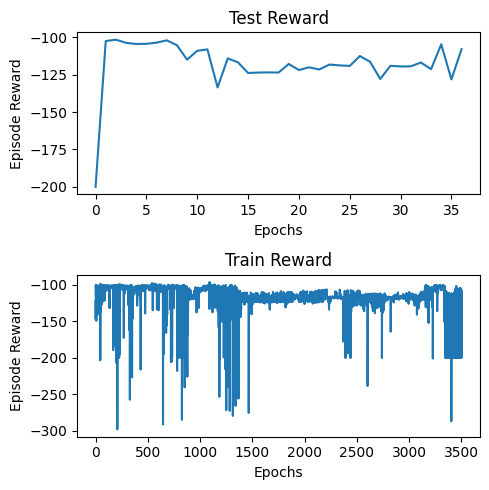

-101.58468309539414
471439


In [152]:
fig, axs = plt.subplots(2, figsize=(5, 5))
x = np.linspace(0, 8000,63)
axs[0].plot(trace_test)
axs[0].set_title('Test Reward')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Episode Reward')

axs[1].plot(trace_rew)
axs[1].set_title('Train Reward')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Episode Reward')
plt.tight_layout()
plt.show()
print(max(trace_test))
print(step_count)

In [154]:
model_path = '/content/gdrive/MyDrive/STAT 421 models/bw1.pt'
torch.save(actor.state_dict(), model_path)